## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from scipy.signal import hilbert
import gammatone.filters
from gammatone.gtgram import gtgram
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Concatenate, LSTM
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc



## Load the Dataset

In [2]:
emotion_map = {
    '01': 'Netral',
    '02': 'Senang',
    '03': 'Terkejut',
    '04': 'Jijik',
    '05': 'Kecewa'
}

In [3]:
paths = []
actors = []
genders = []
emotions = []
intensities = []
repetitions = []

base_dir = 'dataset/IndoWaveSentiment/'
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                paths.append(os.path.join(actor_path, filename))
                parts = filename.replace('.wav', '').split('-')
                actor = parts[0]
                emotion = parts[1]
                intensity = parts[2]
                repetition = parts[3]
                actors.append(actor)
                genders.append('Pria' if int(actor) % 2 == 1 else 'Wanita')
                emotions.append(emotion_map[emotion])
                intensities.append('Normal' if intensity == '01' else 'Strong')
                repetitions.append(repetition)

In [4]:
len(paths)

300

In [5]:
paths[:5]

['dataset/IndoWaveSentiment/Actor_01\\01-01-01-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-02.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-03.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-02.wav']

In [6]:
actor[:5]

'10'

In [7]:
genders[:5]

['Pria', 'Pria', 'Pria', 'Pria', 'Pria']

In [8]:
emotions[:5]

['Netral', 'Netral', 'Netral', 'Netral', 'Netral']

In [10]:
intensities[:5]

['Normal', 'Normal', 'Normal', 'Strong', 'Strong']

In [11]:
repetitions[:5]

['01', '02', '03', '01', '02']

In [5]:
## Create a dataframe
df = pd.DataFrame({
    'path': paths,
    'aktor': actors,
    'gender': genders,
    'emosi': emotions,
    'intensitas': intensities,
    'repetisi': repetitions
})
df.head()

,path,aktor,gender,emosi,intensitas,repetisi
0,dataset/IndoWaveSentiment/Actor_01\01-01-01-01...,01,Pria,Netral,Normal,01
1,dataset/IndoWaveSentiment/Actor_01\01-01-01-02...,01,Pria,Netral,Normal,02
2,dataset/IndoWaveSentiment/Actor_01\01-01-01-03...,01,Pria,Netral,Normal,03
3,dataset/IndoWaveSentiment/Actor_01\01-01-02-01...,01,Pria,Netral,Strong,01
4,dataset/IndoWaveSentiment/Actor_01\01-01-02-02...,01,Pria,Netral,Strong,02


In [13]:
df['path'].value_counts()

path
dataset/IndoWaveSentiment/Actor_01\01-01-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-02.wav    1
                                                     ..
dataset/IndoWaveSentiment/Actor_04\04-02-02-01.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-03.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-02.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-01.wav    1
dataset/IndoWaveSentiment/Actor_10\10-05-02-03.wav    1
Name: count, Length: 300, dtype: int64

In [14]:
df['aktor'].value_counts()

aktor
01    30
02    30
03    30
04    30
05    30
06    30
07    30
08    30
09    30
10    30
Name: count, dtype: int64

In [15]:
df['gender'].value_counts()

gender
Pria      150
Wanita    150
Name: count, dtype: int64

In [16]:
df['emosi'].value_counts()

emosi
Netral      60
Senang      60
Terkejut    60
Jijik       60
Kecewa      60
Name: count, dtype: int64

In [17]:
df['intensitas'].value_counts()

intensitas
Normal    150
Strong    150
Name: count, dtype: int64

In [18]:
df['repetisi'].value_counts()

repetisi
01    100
02    100
03    100
Name: count, dtype: int64

## Exploratory Data Analysis

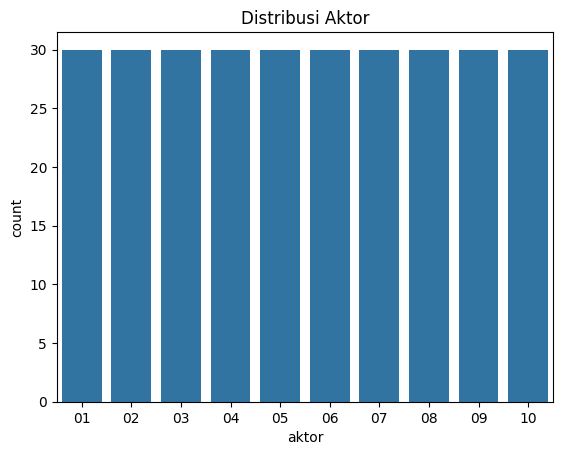

In [19]:
sns.countplot(data=df, x='aktor')
plt.title('Distribusi Aktor')
plt.show()

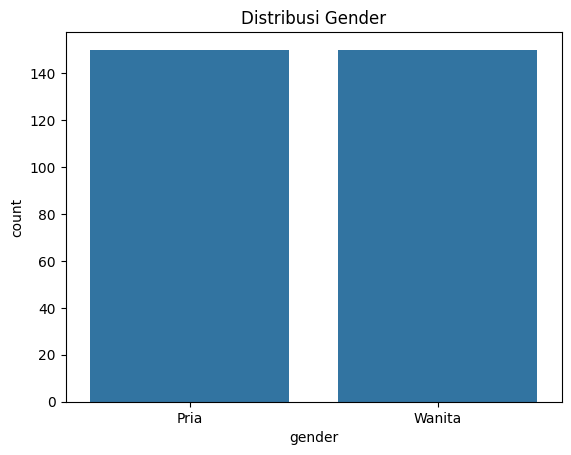

In [20]:
sns.countplot(data=df, x='gender')
plt.title('Distribusi Gender')
plt.show()

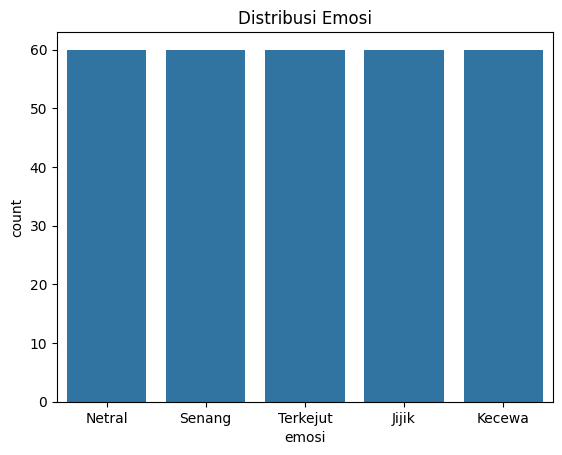

In [21]:
sns.countplot(data=df, x='emosi')
plt.title('Distribusi Emosi')
plt.show()

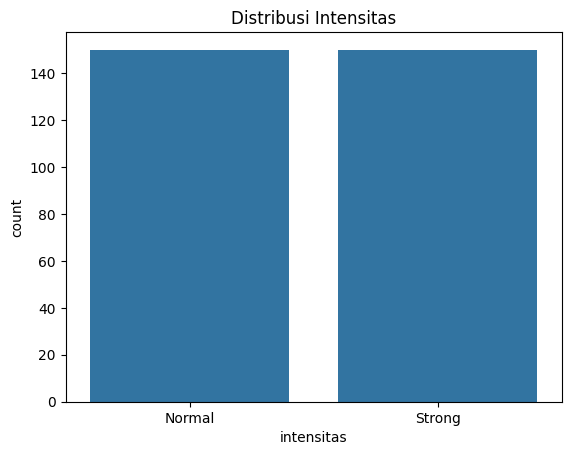

In [22]:
sns.countplot(data=df, x='intensitas')
plt.title('Distribusi Intensitas')
plt.show()

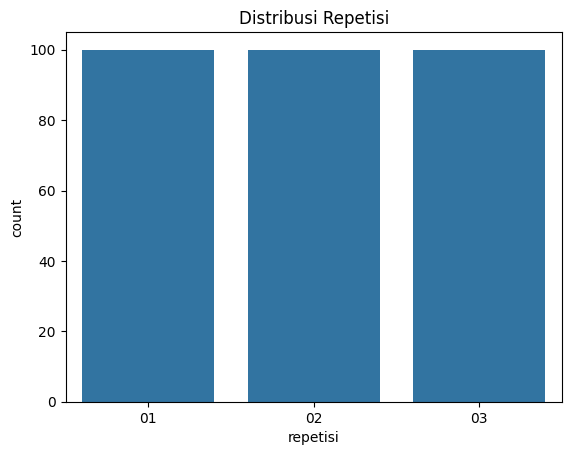

In [23]:
sns.countplot(data=df, x='repetisi')
plt.title('Distribusi Repetisi')
plt.show()

In [24]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

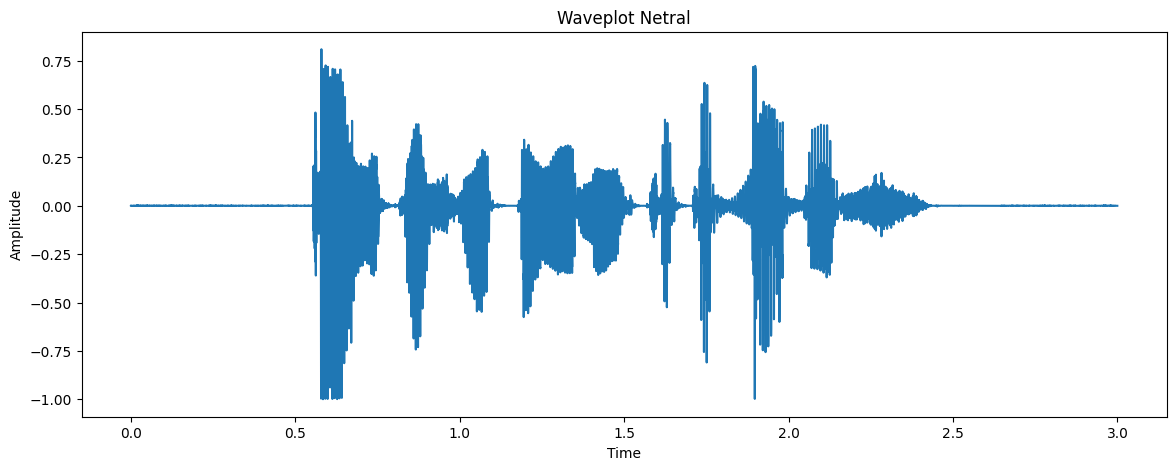

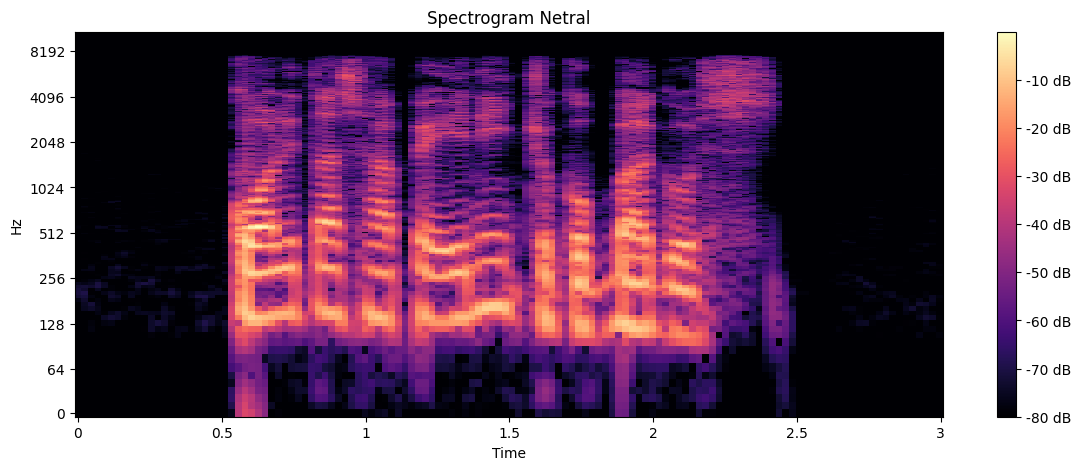

In [25]:
emotion = 'Netral'
paths = np.array(df['path'][df['emosi'] == emotion])[0]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Netral')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Netral')
plt.show()
Audio(paths)

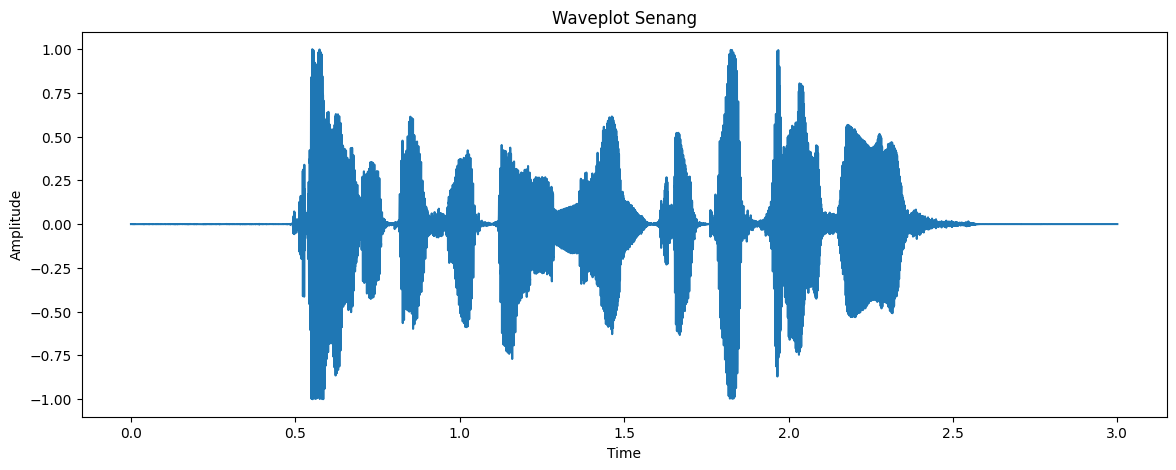

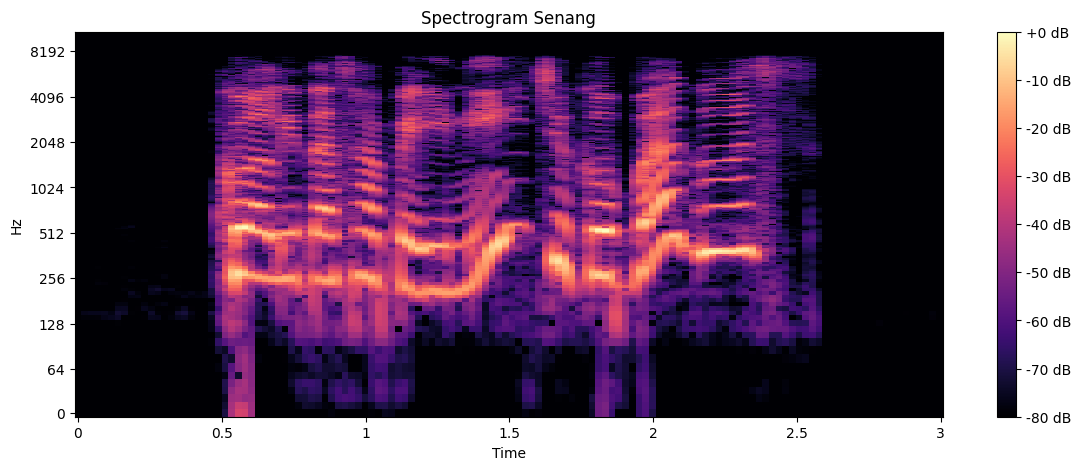

In [26]:
emotion = 'Senang'
paths = np.array(df['path'][df['emosi'] == emotion])[10]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Senang')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Senang')
plt.show()
Audio(paths)

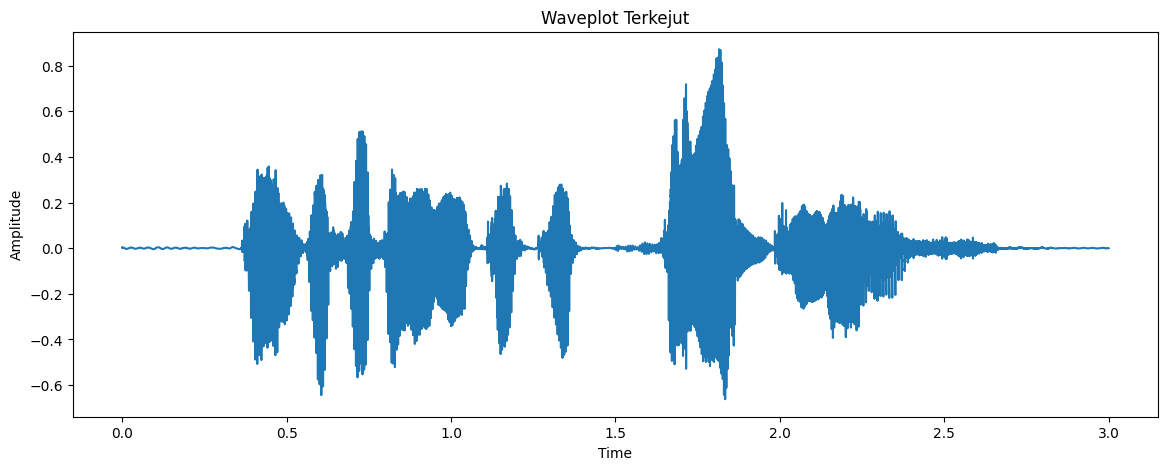

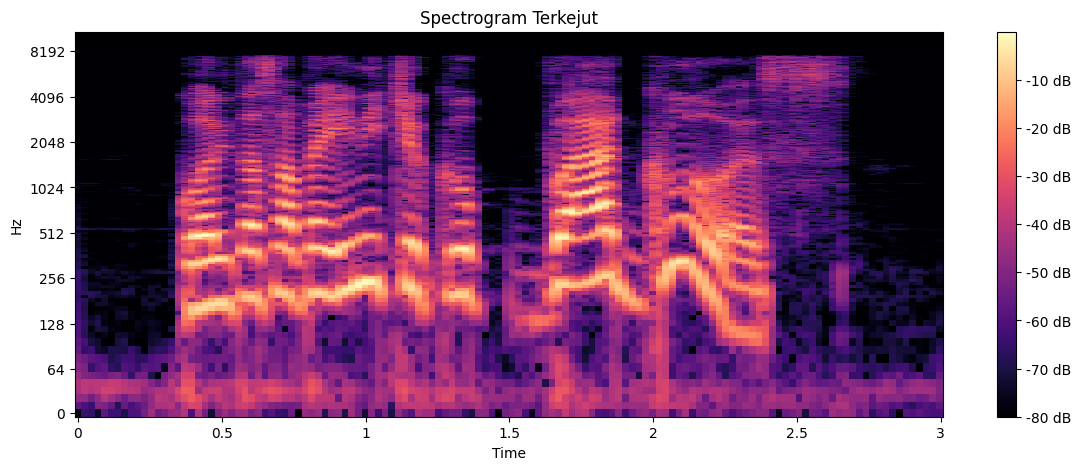

In [27]:
emotion = 'Terkejut'
paths = np.array(df['path'][df['emosi'] == emotion])[16]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Terkejut')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Terkejut')
plt.show()
Audio(paths)

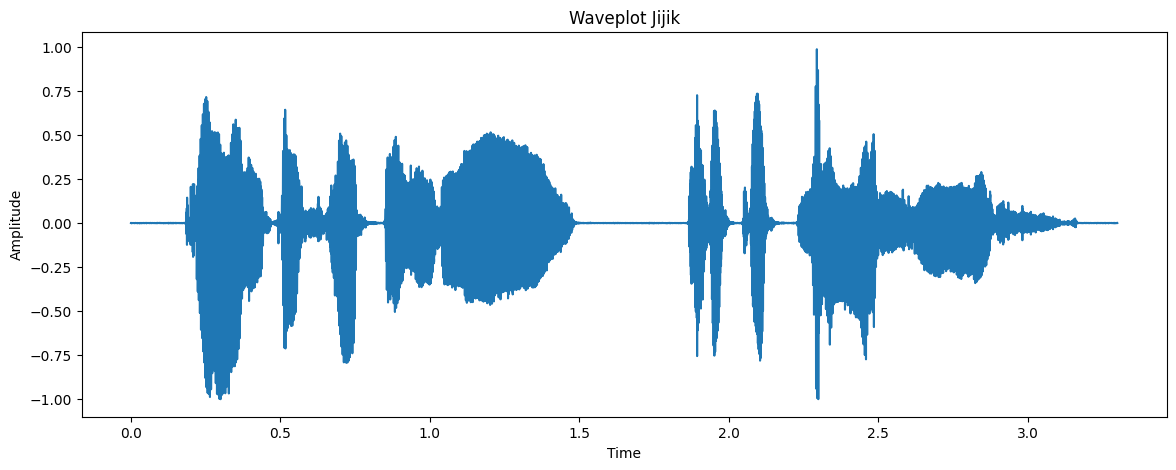

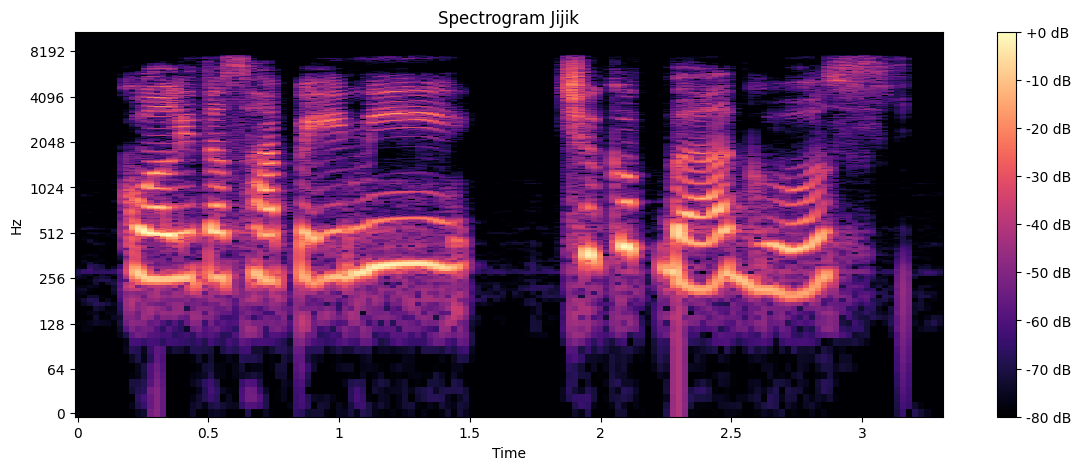

In [28]:
emotion = 'Jijik'
paths = np.array(df['path'][df['emosi'] == emotion])[35]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Jijik')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Jijik')
plt.show()
Audio(paths)

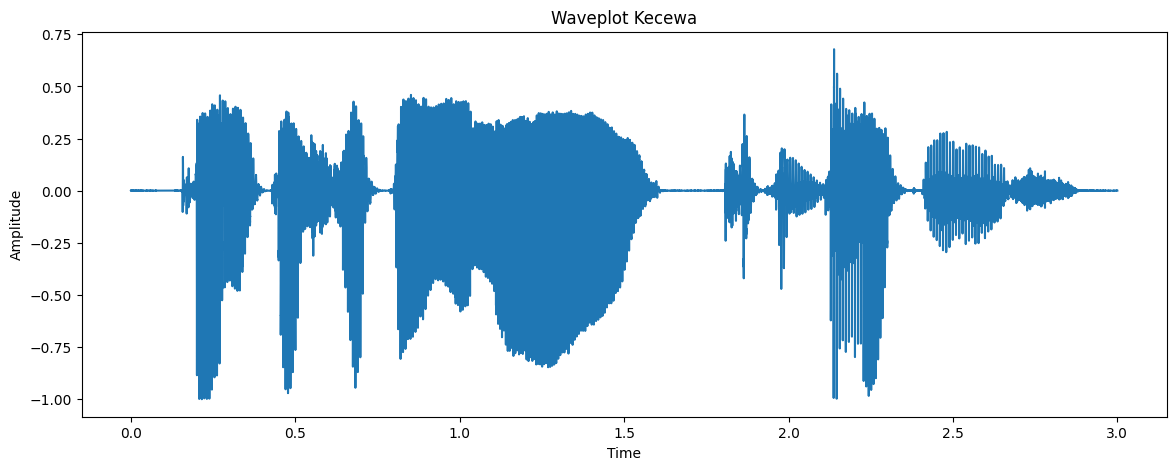

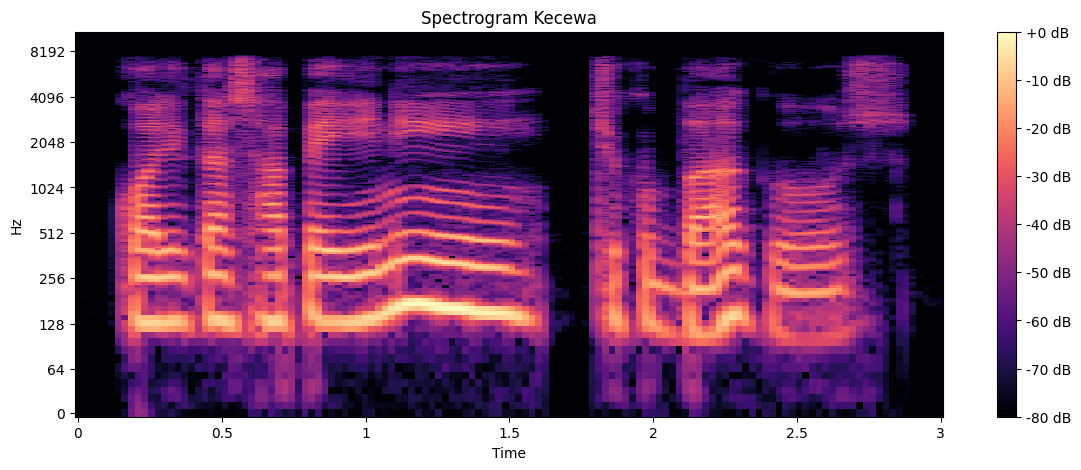

In [29]:
emotion = 'Kecewa'
paths = np.array(df['path'][df['emosi'] == emotion])[50]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Kecewa')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Kecewa')
plt.show()
Audio(paths)

## Feature Extraction

### MFCC

In [6]:
def extract_mfcc(filename, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

In [31]:
extract_mfcc(df['path'][0])

array([-310.3727   ,   89.42707  ,   -5.002537 ,   45.108185 ,
        -28.18145  ,    1.0313294,  -13.933303 ,   -6.250558 ,
        -18.80358  ,   -8.875765 ,   -7.8153534,  -10.976344 ,
         -1.8067925,  -14.960815 ,    2.9725113,  -13.208093 ,
         -8.190284 ,   -3.730549 ,   -9.972042 ,   -8.8986845,
         -7.6499486,   -6.9391184,   -9.34261  ,   -4.8171773,
         -8.12267  ,   -2.9732068,   -8.181031 ,   -3.566138 ,
         -4.520893 ,   -5.1939845,   -1.5096108,   -6.8051553,
         -1.948944 ,   -4.562287 ,   -2.7517035,   -3.6581802,
         -3.968044 ,   -4.641624 ,   -2.5658946,   -1.1098495],
      dtype=float32)

#### DataFrame

In [7]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))
mfcc = np.stack(X_mfcc.values)
X_mfcc

0      [-310.3727, 89.42707, -5.002537, 45.108185, -2...
1      [-293.58374, 96.594345, -6.6026344, 49.63558, ...
2      [-275.0798, 96.307755, -5.3895497, 52.651905, ...
3      [-300.9955, 86.69134, -4.7884502, 37.07431, -2...
4      [-296.57416, 97.53068, -4.8118505, 43.048214, ...
                             ...                        
295    [-322.98322, 84.86375, 4.3241076, 36.054813, -...
296    [-315.5319, 84.19446, 0.0055141924, 33.952553,...
297    [-342.7631, 94.137825, -1.906536, 30.528961, -...
298    [-367.06488, 98.17489, 11.441321, 34.113586, -...
299    [-342.96817, 88.019485, 0.50365645, 33.983727,...
Name: path, Length: 300, dtype: object

In [8]:
mfcc = [x for x in X_mfcc]
mfcc = np.array(mfcc)
mfcc.shape

(300, 40)

In [9]:
## input split
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(300, 40, 1)

### Multispektrum Hilbert

In [10]:
def extract_hilbert_spectrum(filename, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    analytic_signal = hilbert(y)
    envelope = np.abs(analytic_signal)
    spectrum = np.abs(np.fft.fft(envelope))
    spectrum = spectrum[:len(spectrum)//2]  # Ambil separuh (nyquist)
    # 15 statistik fitur dari envelope/spectrum
    features = [
        np.mean(envelope),
        np.std(envelope),
        np.max(envelope),
        np.min(envelope),
        np.median(envelope),
        np.percentile(envelope, 25),
        np.percentile(envelope, 75),
        np.mean(spectrum),
        np.std(spectrum),
        np.max(spectrum),
        np.min(spectrum),
        np.median(spectrum),
        np.percentile(spectrum, 25),
        np.percentile(spectrum, 75),
        np.sum(envelope**2)  # energy
    ]
    return np.array(features)  # shape: (15,)

In [54]:
extract_hilbert_spectrum(df['path'][0])

array([9.35449079e-02, 1.40711665e-01, 1.12361681e+00, 1.57270449e-06,
       3.63048278e-02, 8.66984032e-04, 1.27265941e-01, 7.11853727e+00,
       4.47804328e+01, 5.15600843e+03, 1.71812081e-03, 1.18510533e+00,
       2.65310123e-01, 4.58525682e+00, 1.57364233e+03])

#### DataFrame

In [11]:
X_hilbert_spectrum = df['path'].apply(lambda x: extract_hilbert_spectrum(x))
hilbert_spectrum = np.stack(X_hilbert_spectrum.values)
X_hilbert_spectrum

0      [0.09354490786790848, 0.14071166515350342, 1.1...
1      [0.10645010322332382, 0.14868754148483276, 1.2...
2      [0.11742860823869705, 0.1643792986869812, 1.17...
3      [0.10615934431552887, 0.15599283576011658, 1.3...
4      [0.1034325584769249, 0.14503887295722961, 1.09...
                             ...                        
295    [0.13537363708019257, 0.14154790341854095, 1.0...
296    [0.14503295719623566, 0.14839957654476166, 1.2...
297    [0.12333542108535767, 0.12206174433231354, 0.4...
298    [0.10406363010406494, 0.10466554015874863, 0.4...
299    [0.12454231083393097, 0.12590137124061584, 0.5...
Name: path, Length: 300, dtype: object

In [12]:
hilbert_spectrum = [x for x in X_hilbert_spectrum]
hilbert_spectrum = np.array(hilbert_spectrum)
hilbert_spectrum.shape

(300, 15)

In [13]:
## input split
hilbert_spectrum = np.expand_dims(hilbert_spectrum, -1)
hilbert_spectrum.shape

(300, 15, 1)

### Cochleagram

In [14]:
def extract_cochleagram(filename, n_bands=64, n_frames=192, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    # window_time dan hop_time diatur agar hasil shape (n_bands, n_frames)
    window_time = duration / n_frames  # agar n_frames sesuai
    hop_time = window_time
    f_min = 50
    cochleagram = gtgram(y, sr, window_time, hop_time, n_bands, f_min)
    # Jika hasil frame lebih dari 192, potong; jika kurang, pad dengan nol
    if cochleagram.shape[1] > n_frames:
        cochleagram = cochleagram[:, :n_frames]
    elif cochleagram.shape[1] < n_frames:
        pad_width = n_frames - cochleagram.shape[1]
        cochleagram = np.pad(cochleagram, ((0,0),(0,pad_width)), mode='constant')
    return cochleagram  # shape: (64, 192)

In [44]:
extract_cochleagram(df['path'][0])

array([[4.91337348e-06, 8.11667645e-06, 6.06231039e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.86839216e-06, 1.25682943e-05, 2.81878935e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.28207932e-06, 2.76306284e-05, 9.68343145e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.21059777e-06, 3.01698054e-06, 3.71400207e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.90283064e-06, 3.26569677e-06, 3.55192106e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.54921173e-06, 3.03134330e-06, 3.20594616e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#### DataFrame

In [15]:
X_cochleagram = df['path'].apply(lambda x: extract_cochleagram(x))
cochleagram = np.stack(X_cochleagram.values)
X_cochleagram

0      [[4.913373483938864e-06, 8.1166764512016e-06, ...
1      [[6.824618864283019e-06, 0.0001690100343466388...
2      [[8.218092616148927e-06, 0.0002184955974315193...
3      [[1.034747513573123e-06, 3.5132294360948932e-0...
4      [[1.2564655560294204e-05, 1.7019994556925606e-...
                             ...                        
295    [[0.003478816660262692, 0.004384567474488146, ...
296    [[0.0023292926851853145, 0.0027096950129284324...
297    [[0.0006631138779481476, 0.0008892090933298828...
298    [[0.0007231276014879019, 0.0007822244463547886...
299    [[5.910112763570589e-05, 0.0001873837622594921...
Name: path, Length: 300, dtype: object

In [16]:
cochleagram = [x for x in X_cochleagram]
cochleagram = np.array(cochleagram)
cochleagram.shape

(300, 64, 192)

In [17]:
## input split
cochleagram = np.expand_dims(cochleagram, -1)
cochleagram.shape

(300, 64, 192, 1)

#### Menggabungkan semua fitur

In [ ]:
mfcc_list = []
hilbert_list = []
cochleagram_list = []

for path in df['path']:
    m, h, c = extract_all_features(path)
    mfcc_list.append(m)
    hilbert_list.append(h)
    cochleagram_list.append(c)
    

X_mfcc = np.array(mfcc_list)  # (n_samples, 40)
X_hilbert = np.array(hilbert_list)  # (n_samples, 15)
X_cochleagram = np.array(cochleagram_list)  # (n_samples, 64, 192)

In [ ]:
extract_all_features(df['path'][0])

## Encoding Label Emosi

In [21]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['emosi']])

In [22]:
y = y.toarray()
y.shape

(300, 5)

In [ ]:
print(mfcc.shape)         # (n_samples, 40, 1)
print(hilbert_spectrum.shape)      # (n_samples, 15, 1)
print(cochleagram.shape)  # (n_samples, 64, 192, 1)
print(y.shape)              # (n_samples, n_classes)

(300, 40, 1)
(300, 15, 1)
(300, 64, 192, 1)
(300, 5)


In [24]:
# Split data
X_train_mfcc, X_test_mfcc, \
X_train_hilbert, X_test_hilbert, \
X_train_cochleagram, X_test_cochleagram, \
y_train, y_test = train_test_split(
    mfcc, hilbert_spectrum, cochleagram, y,
    test_size=0.2, random_state=42, stratify=y
)

## Model CNN

In [25]:
# Input 1: MFCC (1D)
input_mfcc = Input(shape=(40, 1), name='input_mfcc')
x_mfcc = Conv1D(32, kernel_size=1, activation='relu')(input_mfcc)
x_mfcc = MaxPooling1D(pool_size=1)(x_mfcc)
x_mfcc = BatchNormalization()(x_mfcc)
x_mfcc = Dropout(0.3)(x_mfcc)
x_mfcc = Flatten()(x_mfcc)
x_mfcc = Dense(8, activation='relu')(x_mfcc)

# Input 2: Hilbert (1D)
input_hilbert = Input(shape=(15, 1), name='input_hilbert')
x_hilbert = Conv1D(32, kernel_size=1, activation='relu')(input_hilbert)
x_hilbert = MaxPooling1D(pool_size=1)(x_hilbert)
x_hilbert = BatchNormalization()(x_hilbert)
x_hilbert = Dropout(0.3)(x_hilbert)
x_hilbert = Flatten()(x_hilbert)
x_hilbert = Dense(8, activation='relu')(x_hilbert)

# Input 3: Cochleagram (2D)
input_cochleagram = Input(shape=(64, 192, 1), name='input_cochleagram')
x_coch = Conv2D(64, kernel_size=(3,3), activation='relu')(input_cochleagram)
x_coch = MaxPooling2D(pool_size=(2,2))(x_coch)
x_coch = BatchNormalization()(x_coch)
x_coch = Dropout(0.3)(x_coch)
x_coch = Flatten()(x_coch)
x_coch = Dense(8, activation='relu')(x_coch)

# Concatenate all
combined = Concatenate()([x_mfcc, x_hilbert, x_coch])
x = BatchNormalization()(combined)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)  # 5 kelas emosi IndoWaveSentiment

# Build model
model_cnn = Model(inputs=[input_mfcc, input_hilbert, input_cochleagram], outputs=output)
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mfcc (InputLayer)     [(None, 40, 1)]              0         []                            
                                                                                                  
 input_hilbert (InputLayer)  [(None, 15, 1)]              0         []                            
                                                                                                  
 input_cochleagram (InputLa  [(None, 64, 192, 1)]         0         []                            
 yer)                                                                                             
                                                                                                  
 conv1d (Conv1D)             (None, 40, 32)               64        ['input_mfcc[0][0]']      

## Train

In [30]:
history_cnn = model_cnn.fit([mfcc, hilbert_spectrum, cochleagram], y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 31s 3s/step - loss: 1.7836 - accuracy: 0.3042 - val_loss: 2.2263 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 24s 3s/step - loss: 1.5432 - accuracy: 0.4500 - val_loss: 1.5809 - val_accuracy: 0.2333
Epoch 3/50
8/8 [==============================] - 16s 2s/step - loss: 1.4394 - accuracy: 0.4167 - val_loss: 1.4527 - val_accuracy: 0.3333
Epoch 4/50
8/8 [==============================] - 16s 2s/step - loss: 1.1715 - accuracy: 0.5583 - val_loss: 1.4500 - val_accuracy: 0.3167
Epoch 5/50
8/8 [==============================] - 23s 3s/step - loss: 1.1309 - accuracy: 0.5458 - val_loss: 1.4847 - val_accuracy: 0.3500
Epoch 6/50
8/8 [==============================] - 20s 2s/step - loss: 1.1612 - accuracy: 0.5417 - val_loss: 1.5287 - val_accuracy: 0.2833
Epoch 7/50
8/8 [==============================] - 19s 2s/step - loss: 1.0473 - accuracy: 0.5750 - val_loss: 1.5283 - val_accuracy: 0.3833
Epoch 8/50
8/8 [==================

In [ ]:
# Simpan model yang telah dilatih
model_cnn.save('dataset/Hybrid_ModelCNN.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN

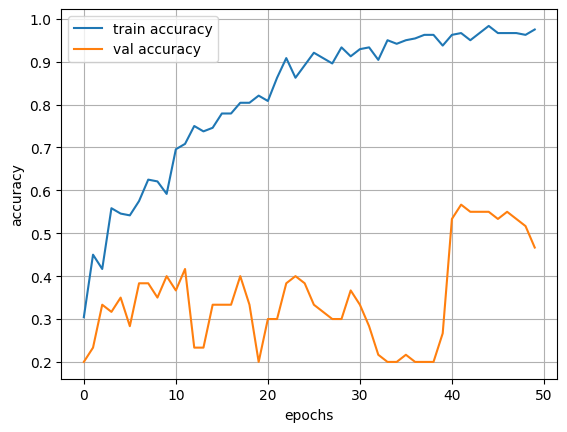

In [31]:
epochs = list(range(len(history_cnn.history['accuracy'])))
plt.plot(epochs, history_cnn.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

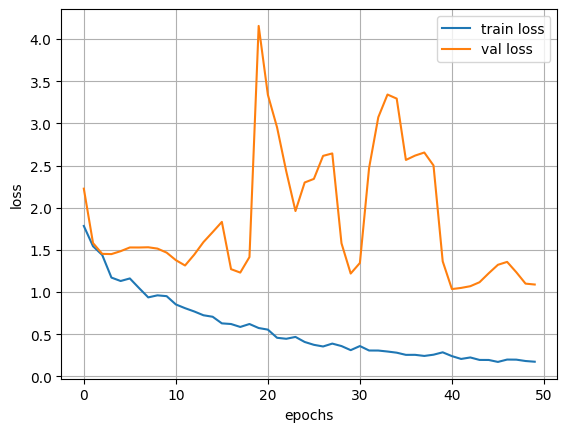

In [32]:
plt.plot(epochs, history_cnn.history['loss'], label='train loss')
plt.plot(epochs, history_cnn.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN

In [33]:
# Prediksi
y_pred_proba_cnn = model_cnn.predict([X_test_mfcc, X_test_hilbert, X_test_cochleagram])
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

2/2 [==============================] - 1s 177ms/step


### Confusion Matrix CNN

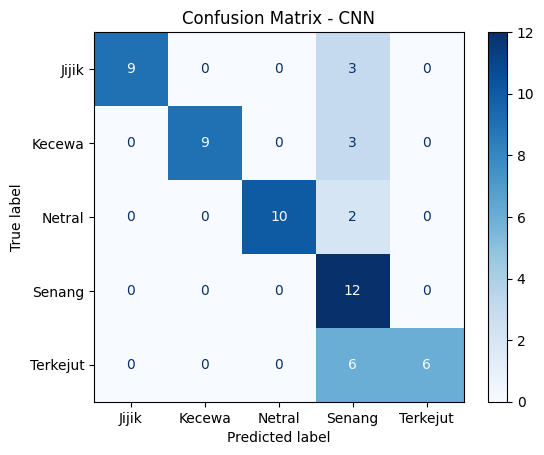

In [34]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN)

In [35]:
print("Akurasi CNN:", accuracy_score(y_true_cnn, y_pred_cnn))
print("Precision (macro):", precision_score(y_true_cnn, y_pred_cnn, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn, y_pred_cnn, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn, y_pred_cnn, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn, y_pred_cnn, target_names=labels))

Akurasi CNN: 0.7666666666666667
Precision (macro): 0.8923076923076924
Recall (macro): 0.7666666666666667
F1-score (macro): 0.7843244474823421

Classification Report:
               precision    recall  f1-score   support

       Jijik       1.00      0.75      0.86        12
      Kecewa       1.00      0.75      0.86        12
      Netral       1.00      0.83      0.91        12
      Senang       0.46      1.00      0.63        12
    Terkejut       1.00      0.50      0.67        12

    accuracy                           0.77        60
   macro avg       0.89      0.77      0.78        60
weighted avg       0.89      0.77      0.78        60



### AUC-ROC CNN

In [36]:
auc_roc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) CNN:", auc_roc_cnn)

AUC-ROC (macro, ovr) CNN: 0.9965277777777779


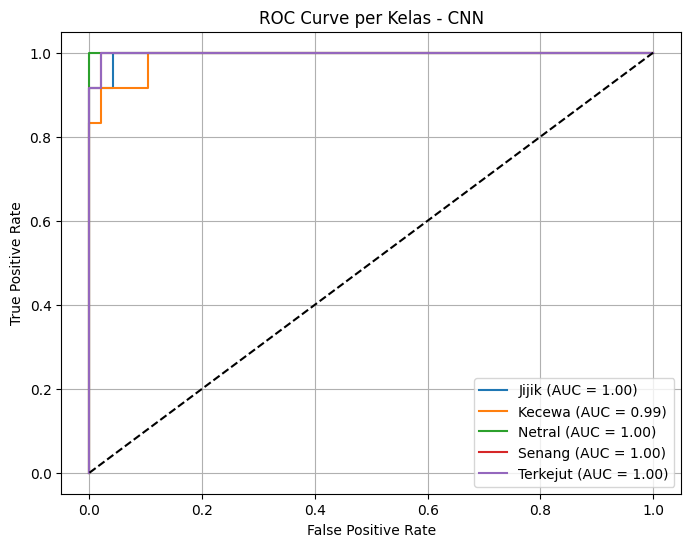

In [37]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_cnn[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN')
plt.legend()
plt.grid(True)
plt.show()

## Model LSTM

In [38]:
# Input 1: MFCC (1, 40)
input_mfcc = Input(shape=(40, 1), name='input_mfcc')
x_mfcc = LSTM(64, return_sequences=False)(input_mfcc)
x_mfcc = Dropout(0.4)(x_mfcc)
x_mfcc = Dense(8, activation='relu')(x_mfcc)

# Input 2: Hilbert (1, 15)
input_hilbert = Input(shape=(15, 1), name='input_hilbert')
x_hilbert = LSTM(128, return_sequences=False)(input_hilbert)
x_hilbert = Dropout(0.4)(x_hilbert)
x_hilbert = Dense(8, activation='relu')(x_hilbert)

# Input 3: Cochleagram (64, 192)
input_cochleagram = Input(shape=(64, 192), name='input_cochleagram')
x_coch = LSTM(64, return_sequences=True)(input_cochleagram)
x_coch = LSTM(16, return_sequences=False)(x_coch)
x_coch = Dropout(0.4)(x_coch)
x_coch = Dense(8, activation='relu')(x_coch)

# Concatenate all
combined = Concatenate()([x_mfcc, x_hilbert, x_coch])
x = Dropout(0.4)(combined)
output = Dense(5, activation='softmax')(x)  # 5 kelas emosi IndoWaveSentiment

# Build model
model_lstm = Model(inputs=[input_mfcc, input_hilbert, input_cochleagram], outputs=output)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cochleagram (InputLa  [(None, 64, 192)]            0         []                            
 yer)                                                                                             
                                                                                                  
 input_mfcc (InputLayer)     [(None, 40, 1)]              0         []                            
                                                                                                  
 input_hilbert (InputLayer)  [(None, 15, 1)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 64, 64)               65792     ['input_cochleagram[0][0

In [39]:
history_lstm = model_lstm.fit([mfcc, hilbert_spectrum, cochleagram], y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 40s 2s/step - loss: 1.6496 - accuracy: 0.2542 - val_loss: 1.6242 - val_accuracy: 0.2167
Epoch 2/50
8/8 [==============================] - 3s 392ms/step - loss: 1.6198 - accuracy: 0.2625 - val_loss: 1.6151 - val_accuracy: 0.1667
Epoch 3/50
8/8 [==============================] - 4s 499ms/step - loss: 1.6398 - accuracy: 0.2083 - val_loss: 1.6052 - val_accuracy: 0.1833
Epoch 4/50
8/8 [==============================] - 4s 507ms/step - loss: 1.6193 - accuracy: 0.1917 - val_loss: 1.5946 - val_accuracy: 0.2500
Epoch 5/50
8/8 [==============================] - 4s 503ms/step - loss: 1.5843 - accuracy: 0.2583 - val_loss: 1.5850 - val_accuracy: 0.2667
Epoch 6/50
8/8 [==============================] - 4s 516ms/step - loss: 1.6215 - accuracy: 0.1792 - val_loss: 1.5761 - val_accuracy: 0.2833
Epoch 7/50
8/8 [==============================] - 4s 484ms/step - loss: 1.5873 - accuracy: 0.3000 - val_loss: 1.5426 - val_accuracy: 0.2333
Epoch 8/50
8/8 [======

In [ ]:
# Simpan model yang telah dilatih
model_lstm.save('dataset/Hybrid_ModelLSTM.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM

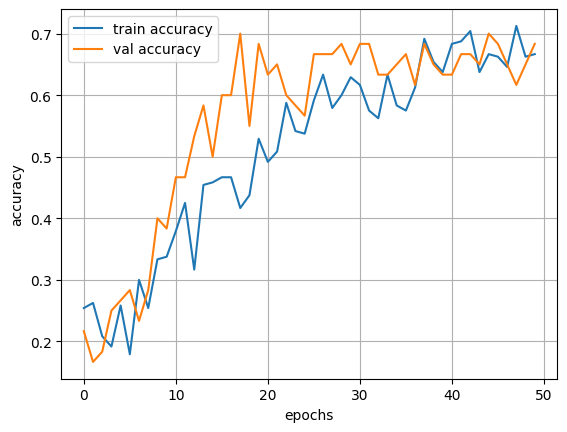

In [40]:
epochs = list(range(len(history_lstm.history['accuracy'])))
plt.plot(epochs, history_lstm.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

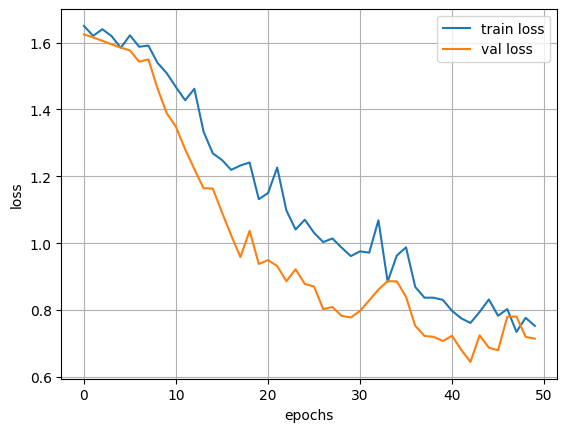

In [41]:
plt.plot(epochs, history_lstm.history['loss'], label='train loss')
plt.plot(epochs, history_lstm.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi LSTM

In [42]:
# Prediksi probabilitas
y_pred_proba_lstm = model_lstm.predict([X_test_mfcc, X_test_hilbert, X_test_cochleagram])
# Prediksi kelas
y_pred_lstm = y_pred_proba_lstm.argmax(axis=1)
y_true_lstm = y_test.argmax(axis=1)

2/2 [==============================] - 7s 140ms/step


### Confusion Matrix

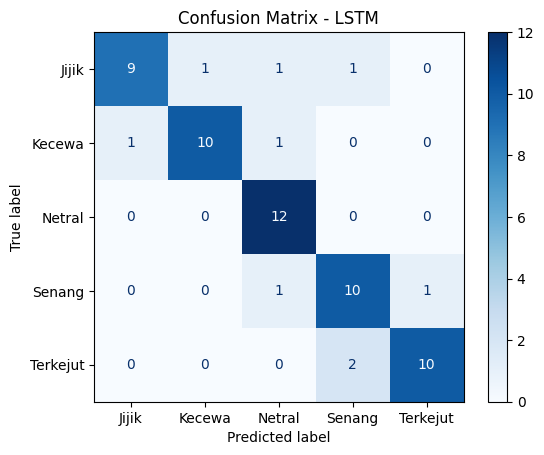

In [43]:
cm = confusion_matrix(y_true_lstm, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM)

In [44]:
print("Akurasi LSTM:", accuracy_score(y_true_lstm, y_pred_lstm))
print("Precision (macro):", precision_score(y_true_lstm, y_pred_lstm, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm, y_pred_lstm, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm, y_pred_lstm, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm, y_pred_lstm, target_names=labels))

Akurasi LSTM: 0.85
Precision (macro): 0.8574825174825176
Recall (macro): 0.85
F1-score (macro): 0.8492402283706632

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.90      0.75      0.82        12
      Kecewa       0.91      0.83      0.87        12
      Netral       0.80      1.00      0.89        12
      Senang       0.77      0.83      0.80        12
    Terkejut       0.91      0.83      0.87        12

    accuracy                           0.85        60
   macro avg       0.86      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



### AUC-ROC LSTM

In [45]:
auc_roc_lstm = roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) LSTM:", auc_roc_lstm)

AUC-ROC (macro, ovr) LSTM: 0.9631944444444445


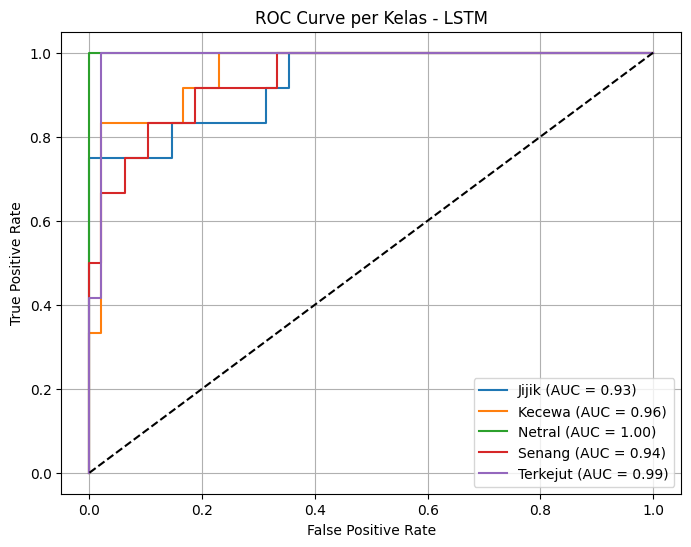

In [46]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_lstm[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM')
plt.legend()
plt.grid(True)
plt.show()

## Model CNN + LSTM

In [48]:
# Input 1: MFCC (1, 40)
input_mfcc = Input(shape=(40, 1), name='input_mfcc')
x_mfcc = Conv1D(32, kernel_size=1, activation='relu')(input_mfcc)
x_mfcc = MaxPooling1D(pool_size=1)(x_mfcc)
x_mfcc = BatchNormalization()(x_mfcc)
x_mfcc = Dropout(0.3)(x_mfcc)
x_mfcc = Flatten()(x_mfcc)
x_mfcc = Dense(8, activation='relu')(x_mfcc)
input_mfcc = Input(shape=(40, 1), name='input_mfcc')
x_mfcc = LSTM(64, return_sequences=False)(input_mfcc)
x_mfcc = Dropout(0.4)(x_mfcc)
x_mfcc = Dense(8, activation='relu')(x_mfcc)

# Input 2: Hilbert (1, 15)
input_hilbert = Input(shape=(15, 1), name='input_hilbert')
x_hilbert = Conv1D(32, kernel_size=1, activation='relu')(input_hilbert)
x_hilbert = MaxPooling1D(pool_size=1)(x_hilbert)
x_hilbert = BatchNormalization()(x_hilbert)
x_hilbert = Dropout(0.3)(x_hilbert)
x_hilbert = Flatten()(x_hilbert)
x_hilbert = Dense(8, activation='relu')(x_hilbert)
input_hilbert = Input(shape=(15, 1), name='input_hilbert')
x_hilbert = LSTM(128, return_sequences=False)(input_hilbert)
x_hilbert = Dropout(0.4)(x_hilbert)
x_hilbert = Dense(8, activation='relu')(x_hilbert)

# Input 3: Cochleagram (64, 192)
input_cochleagram = Input(shape=(64, 192, 1), name='input_cochleagram')
x_coch = Conv2D(64, kernel_size=(3,3), activation='relu')(input_cochleagram)
x_coch = MaxPooling2D(pool_size=(2,2))(x_coch)
x_coch = BatchNormalization()(x_coch)
x_coch = Dropout(0.3)(x_coch)
x_coch = Flatten()(x_coch)
x_coch = Dense(8, activation='relu')(x_coch)
input_cochleagram = Input(shape=(64, 192), name='input_cochleagram')
x_coch = LSTM(64, return_sequences=True)(input_cochleagram)
x_coch = LSTM(16, return_sequences=False)(x_coch)
x_coch = Dropout(0.4)(x_coch)
x_coch = Dense(8, activation='relu')(x_coch)

# Concatenate all
combined = Concatenate()([x_mfcc, x_hilbert, x_coch])
x = BatchNormalization()(combined)
x = Dropout(0.4)(x)
output = Dense(5, activation='softmax')(x)  # 5 kelas emosi IndoWaveSentiment

# Build model
model_hybrid = Model(inputs=[input_mfcc, input_hilbert, input_cochleagram], outputs=output)
model_hybrid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_hybrid.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_cochleagram (InputLa  [(None, 64, 192)]            0         []                            
 yer)                                                                                             
                                                                                                  
 input_mfcc (InputLayer)     [(None, 40, 1)]              0         []                            
                                                                                                  
 input_hilbert (InputLayer)  [(None, 15, 1)]              0         []                            
                                                                                                  
 lstm_9 (LSTM)               (None, 64, 64)               65792     ['input_cochleagram[0][0

In [49]:
history_hybrid = model_hybrid.fit([mfcc, hilbert_spectrum, cochleagram], y, validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 38s 2s/step - loss: 2.1286 - accuracy: 0.1917 - val_loss: 1.6648 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 2s 282ms/step - loss: 2.1107 - accuracy: 0.2125 - val_loss: 1.6651 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 4s 502ms/step - loss: 2.1489 - accuracy: 0.1958 - val_loss: 1.6647 - val_accuracy: 0.1833
Epoch 4/50
8/8 [==============================] - 4s 549ms/step - loss: 2.0443 - accuracy: 0.2125 - val_loss: 1.6529 - val_accuracy: 0.1500
Epoch 5/50
8/8 [==============================] - 4s 502ms/step - loss: 1.7985 - accuracy: 0.2667 - val_loss: 1.6405 - val_accuracy: 0.1667
Epoch 6/50
8/8 [==============================] - 4s 507ms/step - loss: 1.7972 - accuracy: 0.2917 - val_loss: 1.6175 - val_accuracy: 0.2167
Epoch 7/50
8/8 [==============================] - 4s 513ms/step - loss: 1.7983 - accuracy: 0.2833 - val_loss: 1.6404 - val_accuracy: 0.2000
Epoch 8/50
8/8 [======

In [ ]:
# Simpan model yang telah dilatih
model_hybrid.save('dataset/Hybrid_ModelHybrid.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi Hybrid

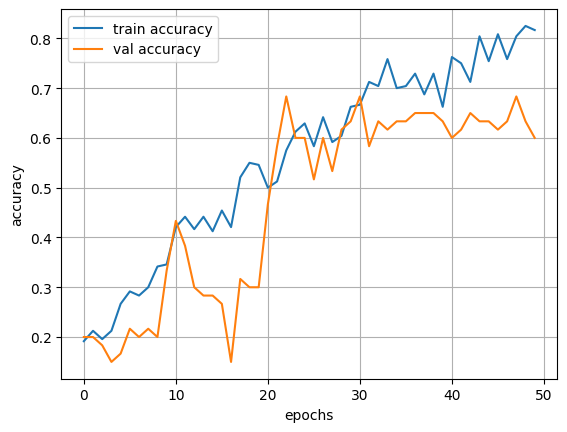

In [50]:
epochs = list(range(len(history_hybrid.history['accuracy'])))
plt.plot(epochs, history_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

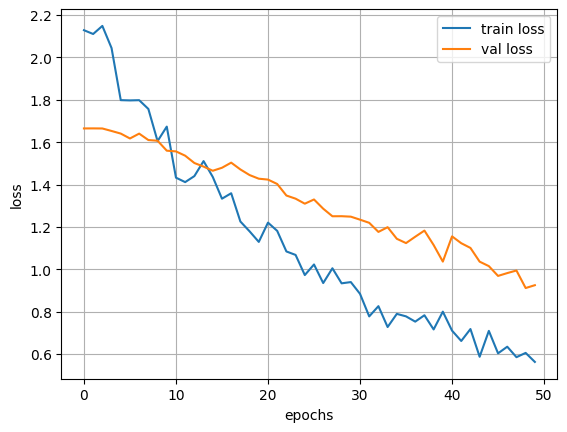

In [51]:
plt.plot(epochs, history_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Prediksi probabilitas
y_pred_proba_hybrid = model_hybrid.predict([X_test_mfcc, X_test_hilbert, X_test_cochleagram])
# Prediksi kelas
y_pred_hybrid = y_pred_proba_hybrid.argmax(axis=1)
y_true_hybrid = y_test.argmax(axis=1)

2/2 [==============================] - 4s 90ms/step


### Confusion Matrix

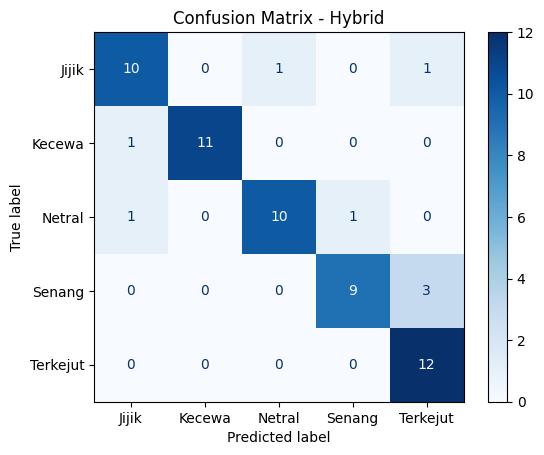

In [56]:
cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Hybrid')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics Hybrid)

In [57]:
print("Akurasi Hybrid:", accuracy_score(y_true_hybrid, y_pred_hybrid))
print("Precision (macro):", precision_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybrid, y_pred_hybrid, target_names=labels))

Akurasi Hybrid: 0.8666666666666667
Precision (macro): 0.8784848484848485
Recall (macro): 0.8666666666666668
F1-score (macro): 0.8669489930359495



Classification Report:
               precision    recall  f1-score   support

       Jijik       0.83      0.83      0.83        12
      Kecewa       1.00      0.92      0.96        12
      Netral       0.91      0.83      0.87        12
      Senang       0.90      0.75      0.82        12
    Terkejut       0.75      1.00      0.86        12

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60



### AUC-ROC Hybrid

In [58]:
auc_roc_hybrid = roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) Hybrid:", auc_roc_hybrid)

AUC-ROC (macro, ovr) Hybrid: 0.9916666666666666


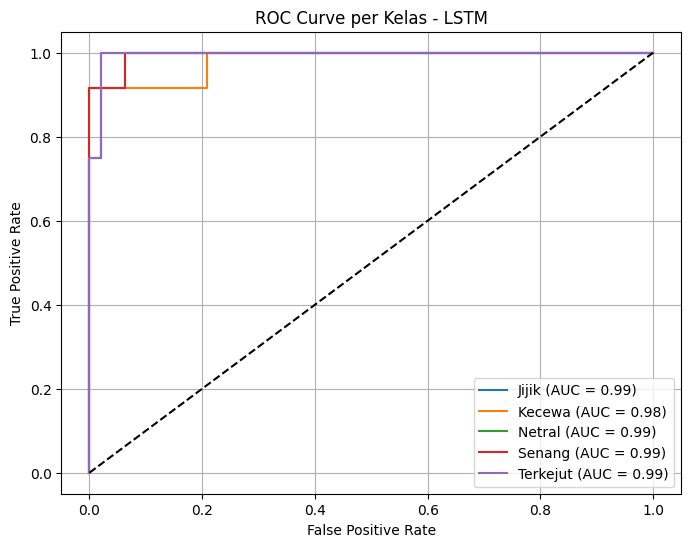

In [59]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Perbandingan Kinerja antar Model

In [61]:
# Kumpulkan semua metrik ke dalam dictionary
metrics_data = {
    'Model': ['CNN', 'LSTM', 'Hybrid'],
    'Akurasi': [
        accuracy_score(y_true_cnn, y_pred_cnn),
        accuracy_score(y_true_lstm, y_pred_lstm),
        accuracy_score(y_true_hybrid, y_pred_hybrid)
    ],
    'Precision (macro)': [
        precision_score(y_true_cnn, y_pred_cnn, average='macro'),
        precision_score(y_true_lstm, y_pred_lstm, average='macro'),
        precision_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_true_cnn, y_pred_cnn, average='macro'),
        recall_score(y_true_lstm, y_pred_lstm, average='macro'),
        recall_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_true_cnn, y_pred_cnn, average='macro'),
        f1_score(y_true_lstm, y_pred_lstm, average='macro'),
        f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'AUC-ROC (macro)': [
        roc_auc_score(y_test, y_pred_proba_cnn, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_lstm, average='macro', multi_class='ovr'),
        roc_auc_score(y_test, y_pred_proba_hybrid, average='macro', multi_class='ovr')
    ]
}

# Buat DataFrame
comparison_df = pd.DataFrame(metrics_data)
print("Tabel Perbandingan Kinerja Model:")
print(comparison_df.to_string())

Tabel Perbandingan Kinerja Model:
    Model   Akurasi  Precision (macro)  Recall (macro)  F1-score (macro)  AUC-ROC (macro)
0     CNN  0.766667           0.892308        0.766667          0.784324         0.996528
1    LSTM  0.850000           0.857483        0.850000          0.849240         0.963194
2  Hybrid  0.866667           0.878485        0.866667          0.866949         0.991667


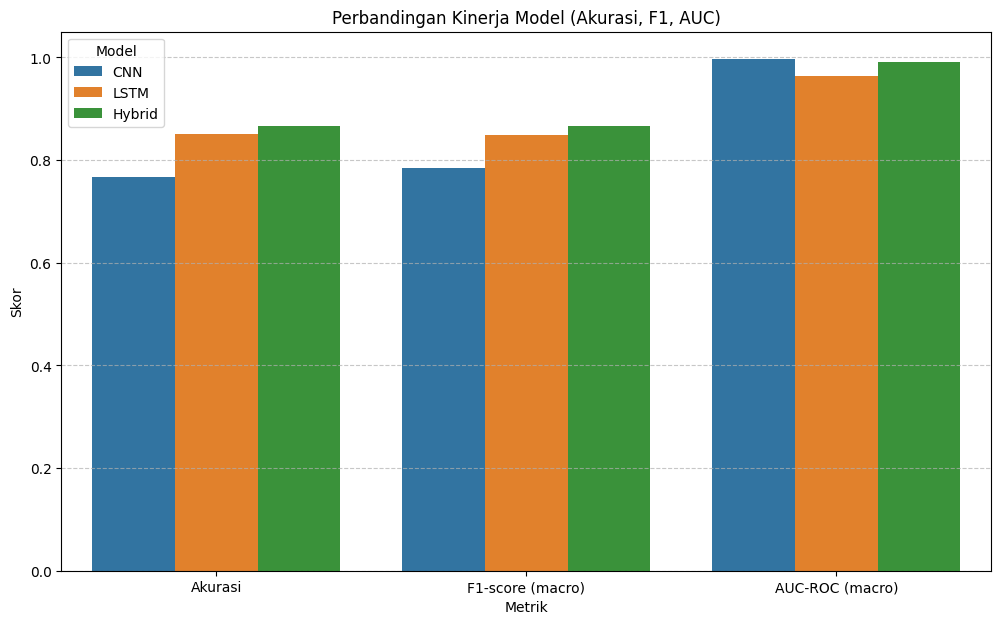

In [62]:
# Siapkan data untuk plot
plot_df = comparison_df.melt(id_vars='Model', value_vars=['Akurasi', 'F1-score (macro)', 'AUC-ROC (macro)'],
                             var_name='Metrik', value_name='Skor')

# Buat bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Metrik', y='Skor', hue='Model')
plt.title('Perbandingan Kinerja Model (Akurasi, F1, AUC)')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [63]:
# Siapkan probabilitas dari setiap model
models_proba = {
    'CNN': y_pred_proba_cnn,
    'LSTM': y_pred_proba_lstm,
    'Hybrid': y_pred_proba_hybrid
}

plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

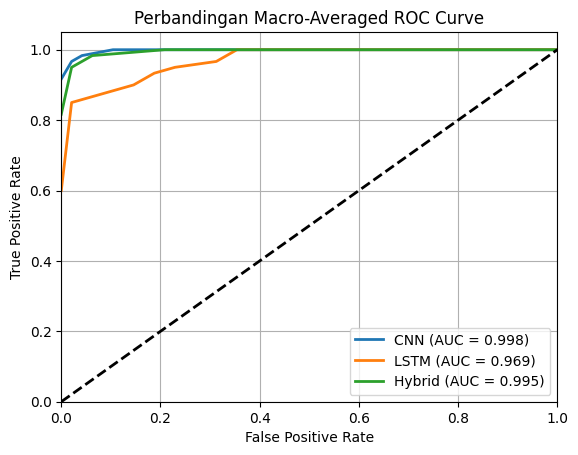

In [64]:
# Loop untuk setiap model
for model_name, y_pred_proba in models_proba.items():
    # Hitung macro-average ROC
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'{model_name} (AUC = {macro_auc:.3f})',
             linewidth=2)

# Plot garis referensi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Macro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()